In [1]:
import tensorflow as tf

In [2]:
import numpy as np
from zipfile import ZipFile
import gradio as gr
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import cv2
import random
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras import layers, regularizers
from tensorflow.keras.utils import to_categorical


/opt/anaconda3/envs/tensorenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path_train = "/Users/vishvatejaguduguntla/Downloads/chest_xray/train"
print(os.listdir(path_train))
classes = os.listdir(path_train)


['.DS_Store', 'PNEUMONIA', 'NORMAL']


In [4]:
path_test = "/Users/vishvatejaguduguntla/Downloads/chest_xray/test"
print(os.listdir(path_train))

['.DS_Store', 'PNEUMONIA', 'NORMAL']


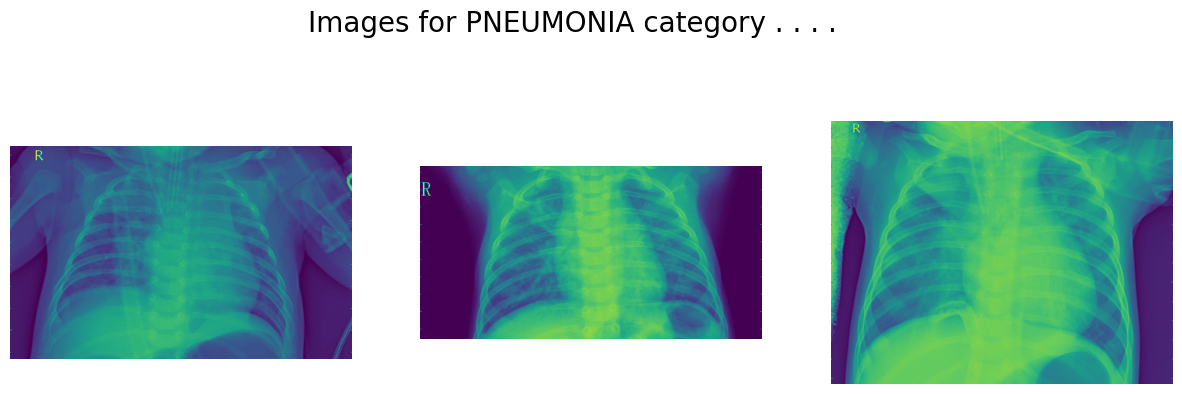

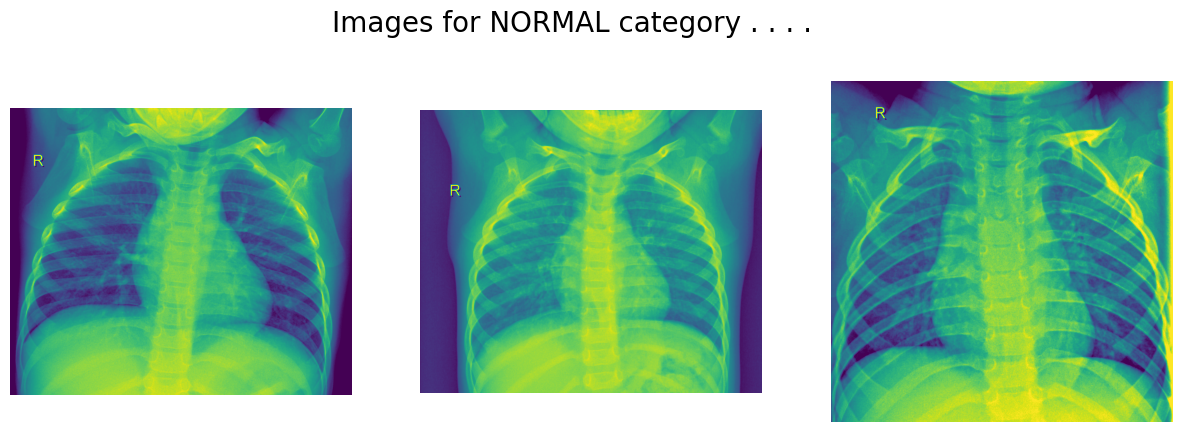

In [5]:
for cat in classes:
  if cat != ".DS_Store" and os.path.isdir(os.path.join(path_train, cat)):
    image_dir = f'{path_train}/{cat}'
    images = os.listdir(image_dir)
    images = [img for img in images if os.path.isfile(os.path.join(image_dir, img))]
    fig, ax = plt.subplots(1, 3, figsize = (15, 5))
    fig.suptitle(f'Images for {cat} category . . . .',
                 fontsize = 20)

    for i in range(3):
        if images:
            k = np.random.randint(0, len(images))
            img = np.array(Image.open(f'{path_train}/{cat}/{images[k]}'))
            ax[i].imshow(img)
            ax[i].axis('off')
        else:
            print(f"No images found in directory: {image_dir}")
    plt.show()

In [6]:
train_folder = ["/Users/vishvatejaguduguntla/Downloads/chest_xray/train/NORMAL","/Users/vishvatejaguduguntla/Downloads/chest_xray/train/PNEUMONIA"]
test_folder = ["/Users/vishvatejaguduguntla/Downloads/chest_xray/test/NORMAL","/Users/vishvatejaguduguntla/Downloads/chest_xray/test/PNEUMONIA"]

IMG_SIZE = 128
SPLIT = 0.2

classes = ["NORMAL","PNEUMONIA"]

X_train,Y_train,X_test,Y_test = [],[],[],[]
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

In [7]:
for i,train_path in  enumerate(train_folder):
  images = glob(f"{train_path}/*.*")
  print(f"Found {len(images)} images in {train_path}")

  for img in images:
    img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    img = clahe.apply(img)
    img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    X_train.append(img)
    Y_train.append(i)

Found 1341 images in /Users/vishvatejaguduguntla/Downloads/chest_xray/train/NORMAL
Found 3875 images in /Users/vishvatejaguduguntla/Downloads/chest_xray/train/PNEUMONIA


In [8]:
for i,test_path in  enumerate(test_folder):
  images = glob(f"{test_path}/*.*")
  print(f"Found {len(images)} images in {test_path}")

  for img in images:
    img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    img = clahe.apply(img)
    img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
    X_test.append(img)
    Y_test.append(i)

Found 234 images in /Users/vishvatejaguduguntla/Downloads/chest_xray/test/NORMAL
Found 390 images in /Users/vishvatejaguduguntla/Downloads/chest_xray/test/PNEUMONIA


In [9]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

# Normalize pixel values to [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

# Print shapes to confirm
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (5216, 128, 128, 3)
Y_train shape: (5216,)
X_test shape: (624, 128, 128)
Y_test shape: (624,)


In [10]:
Y_train = to_categorical(Y_train, num_classes=2)
Y_test = to_categorical(Y_test, num_classes=2)

print("Y_train one-hot shape:", Y_train.shape)
print("Y_test one-hot shape:", Y_test.shape)

Y_train one-hot shape: (5216, 2)
Y_test one-hot shape: (624, 2)


In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)),  # grayscale image
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  # binary output: pneumonia vs normal
])

In [12]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       7

In [14]:
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

# 2. Data Generators (Make sure your folder structure is correct)
train_dir = '/Users/vishvatejaguduguntla/Downloads/chest_xray/train'
val_dir = '/Users/vishvatejaguduguntla/Downloads/chest_xray/test'

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale'  # Use 'rgb' if images are colored
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale'
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [15]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [16]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [17]:

model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop]
)

2025-04-06 15:41:15.001210: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2025-04-06 15:41:15.002905: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/20
163/163 [==============================] - 49s 300ms/step - loss: 0.6147 - accuracy: 0.7281 - val_loss: 0.5217 - val_accuracy: 0.6250
Epoch 2/20
163/163 [==============================] - 60s 366ms/step - loss: 0.3071 - accuracy: 0.8391 - val_loss: 0.5148 - val_accuracy: 0.7724
Epoch 3/20
163/163 [==============================] - 52s 317ms/step - loss: 0.2292 - accuracy: 0.9176 - val_loss: 0.5144 - val_accuracy: 0.7917
Epoch 4/20
163/163 [==============================] - 47s 289ms/step - loss: 0.2037 - accuracy: 0.9306 - val_loss: 0.7062 - val_accuracy: 0.7500
Epoch 5/20
163/163 [==============================] - 47s 289ms/step - loss: 0.1850 - accuracy: 0.9427 - val_loss: 0.5648 - val_accuracy: 0.8077
Epoch 6/20
163/163 [==============================] - 47s 287ms/step - loss: 0.1641 - accuracy: 0.9434 - val_loss: 0.6371 - val_accuracy: 0.7756


In [32]:
model.predict(val_generator)

array([[0.39614832],
       [0.9769191 ],
       [0.7379637 ],
       [0.99223053],
       [0.9157612 ],
       [0.6292649 ],
       [0.98989   ],
       [0.5137556 ],
       [0.99824476],
       [0.7414667 ],
       [0.9985945 ],
       [0.95654595],
       [0.76830125],
       [0.95759577],
       [0.8890695 ],
       [0.9862642 ],
       [0.942822  ],
       [0.9669626 ],
       [0.99939764],
       [0.32255805],
       [0.6817577 ],
       [0.9639849 ],
       [0.9935229 ],
       [0.5857328 ],
       [0.95183516],
       [0.63545793],
       [0.9923749 ],
       [0.97152317],
       [0.47317877],
       [0.9700496 ],
       [0.79351085],
       [0.32159522],
       [0.98458475],
       [0.30924532],
       [0.756814  ],
       [0.8046969 ],
       [0.9826548 ],
       [0.9946587 ],
       [0.731758  ],
       [0.96885765],
       [0.7113695 ],
       [0.96093243],
       [0.31884167],
       [0.9790846 ],
       [0.98108673],
       [0.9754989 ],
       [0.6940297 ],
       [0.881

In [33]:
# Get true labels
val_generator.reset()
y_true = val_generator.classes

# Get predicted probabilities
y_pred_prob = model.predict(val_generator)

# Convert predicted probabilities to binary (0 or 1)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)


In [34]:
print("Classification Report:\n")
target_names = list(val_generator.class_indices.keys())  # ['NORMAL', 'PNEUMONIA']
print(classification_report(y_true, y_pred, target_names=target_names))


Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.39      0.23      0.29       234
   PNEUMONIA       0.63      0.78      0.70       390

    accuracy                           0.58       624
   macro avg       0.51      0.51      0.49       624
weighted avg       0.54      0.58      0.55       624



In [35]:
model.save('pneumonia_model.h5')


In [36]:
def predict_pneumonia(img):
    # Resize and convert image to grayscale
    img = img.resize((150, 150)).convert('L')  # 'L' for grayscale
    img_array = np.array(img)
    img_array = img_array.reshape(1, 150, 150, 1)
    img_array = img_array / 255.0

    prediction = model.predict(img_array)[0][0]

    if prediction > 0.5:
        return f"PREDICTION: Pneumonia ({prediction:.2f})"
    else:
        return f"PREDICTION: Normal ({1 - prediction:.2f})"


In [43]:

interface = gr.Interface(
    fn=predict_pneumonia,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=2),
    title="Pneumonia Detection"
)

interface.launch(share=True)  # or inline=True

ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/opt/anaconda3/envs/tensorenv/lib/python3.9/site-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
  File "/opt/anaconda3/envs/tensorenv/lib/python3.9/site-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
  File "/opt/anaconda3/envs/tensorenv/lib/python3.9/site-packages/fastapi/applications.py", line 1054, in __call__
    await super().__call__(scope, receive, send)
  File "/opt/anaconda3/envs/tensorenv/lib/python3.9/site-packages/starlette/applications.py", line 112, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/opt/anaconda3/envs/tensorenv/lib/python3.9/site-packages/starlette/middleware/errors.py", line 187, in __call__
    raise exc
  File "/opt/anaconda3/envs/tensorenv/lib/python3.9/site-packages/starlette/middleware/errors.py",

Running on local URL:  http://127.0.0.1:7865


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/opt/anaconda3/envs/tensorenv/lib/python3.9/site-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
  File "/opt/anaconda3/envs/tensorenv/lib/python3.9/site-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
  File "/opt/anaconda3/envs/tensorenv/lib/python3.9/site-packages/fastapi/applications.py", line 1054, in __call__
    await super().__call__(scope, receive, send)
  File "/opt/anaconda3/envs/tensorenv/lib/python3.9/site-packages/starlette/applications.py", line 112, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/opt/anaconda3/envs/tensorenv/lib/python3.9/site-packages/starlette/middleware/errors.py", line 187, in __call__
    raise exc
  File "/opt/anaconda3/envs/tensorenv/lib/python3.9/site-packages/starlette/middleware/errors.py",


Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


2025/04/06 15:56:18 [W] [service.go:132] login to server failed: dial tcp 44.237.78.176:7000: i/o timeout


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/opt/anaconda3/envs/tensorenv/lib/python3.9/site-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
  File "/opt/anaconda3/envs/tensorenv/lib/python3.9/site-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
  File "/opt/anaconda3/envs/tensorenv/lib/python3.9/site-packages/fastapi/applications.py", line 1054, in __call__
    await super().__call__(scope, receive, send)
  File "/opt/anaconda3/envs/tensorenv/lib/python3.9/site-packages/starlette/applications.py", line 112, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/opt/anaconda3/envs/tensorenv/lib/python3.9/site-packages/starlette/middleware/errors.py", line 187, in __call__
    raise exc
  File "/opt/anaconda3/envs/tensorenv/lib/python3.9/site-packages/starlette/middleware/errors.py",